# Temperature correction of spindle current

We want to take a reference signal and a signal to correct. The goal is to remove the effects of the temperature on the spindle current.

In [1]:
import os
from pathlib import Path
import sys
import pandas as pd
from matplotlib import pyplot as plt


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

current_folder = os.getcwd()
print(current_folder)

from temperatureCorrection.getTemperatureCorrectionData import getTemperatureCorrectionData
from temperatureCorrection.correctSpindleCurrent import correctSpindleCurrent
from utils.detectConstantSegments import detectConstantSegments

/Users/opatiny/git/opatiny/predictiveMaintenance/src/notebooks


## Compute initial temperature correction on each signal

Mecatis 03.02.2025 has faulty spindle temperature sensor.

In [2]:
dataPath: Path = "../../data/normalized-2025_05_08/"


referenceSample: str = "Mecatis_05_02_25.parquet"
sampleToCorrect: str = "Mecatis_17_02_25.parquet"

sampleNames = [
    referenceSample,
    sampleToCorrect,
]

correctedDatas : list[pd.DataFrame] = []
constantSegmentsIndices : list[list[tuple]] = []
lengths : list[int] = [] # nb of points in each sample

for sample in sampleNames:
    print("Current sample: ", sample)

    # Load the data
    samplePath = current_folder / Path(dataPath) / sample
    data = pd.read_parquet(samplePath)
    lengths.append(len(data))

    segmentIndices = detectConstantSegments(data)

    # Correct the spindle current
    correctedCurrent = correctSpindleCurrent(data, segmentIndices, debug=False)

    # compute minimal data subset with only time, temperature and spindle current 
    sample = getTemperatureCorrectionData(data)

    # add corrected current to the minimal data
    sample["correctedCurrent"] = correctedCurrent

    correctedDatas.append(sample)
    constantSegmentsIndices.append(segmentIndices)

Current sample:  Mecatis_05_02_25.parquet
Current sample:  Mecatis_17_02_25.parquet


/Users/opatiny/git/opatiny/predictiveMaintenance/src/utils/polyFit.py:17: RankWarning: Polyfit may be poorly conditioned
  model = np.poly1d(np.polyfit(segment["temperature"], segment["current"], order))


In [3]:
print(constantSegmentsIndices)

[[(893, 84083), (84959, 165527), (166403, 694810), (695686, 772705), (773581, 889295), (890171, 2065465)], [(893, 84072), (84948, 165512), (166388, 694795), (695670, 772677), (773552, 889265), (890141, 2065435)]]


## Clip samples so they all have the same length

We just delete the extra points so all samples have the same nb of points.

In [4]:
minLength = min(lengths)
nbSegments = len(constantSegmentsIndices[0])

# remove extra points in the samples
for i in range(len(correctedDatas)):
    if len(correctedDatas[i]) > minLength:
        correctedDatas[i] = correctedDatas[i].iloc[:minLength]
        constantSegmentsIndices[i][nbSegments-1] = [constantSegmentsIndices[i][nbSegments-1][0], minLength-1] # this is so ugly


# check lengths
for i in range(len(correctedDatas)):
    print(f"Sample {i+1} length: {len(correctedDatas[i])}")
    print("last segment", constantSegmentsIndices[i][nbSegments-1])

Sample 1 length: 2065436
last segment [890171, 2065435]
Sample 2 length: 2065436
last segment (890141, 2065435)


## Plot original spindle current

Initial RMSE:  0.0  A


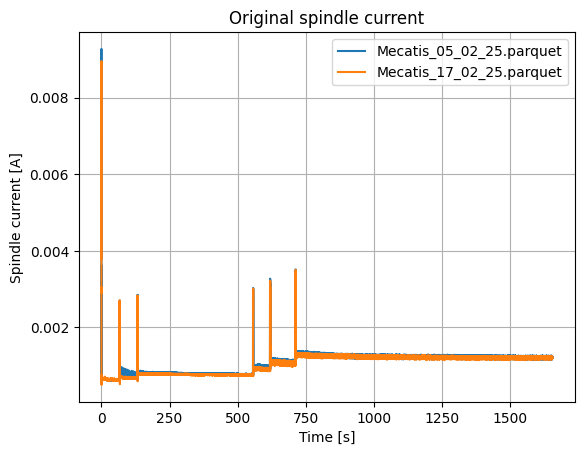

In [5]:
from utils.getRmse import getRmse

# compute error between the two samples
originalRmse = getRmse(correctedDatas[0]["current"], correctedDatas[1]["current"])

print("Initial RMSE: ", round(originalRmse, 3), " A")

# plot the original spindle current
plt.figure()
for i, sample in enumerate(correctedDatas):
    plt.plot(sample["timeSeconds"], sample["current"], label=sampleNames[i])
plt.xlabel("Time [s]")
plt.ylabel("Spindle current [A]")
plt.legend()
plt.title("Original spindle current")
plt.grid()
plt.show()



## Plot the spindle current after first correction

Initial RMSE:  0.0  A


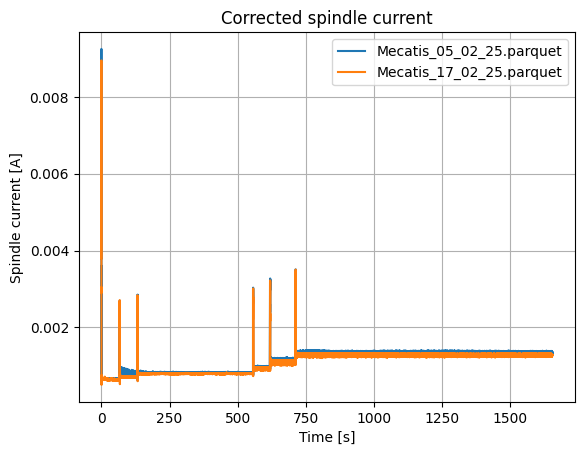

In [6]:
# compute error between the two samples
correctedRmse = getRmse(correctedDatas[0]["correctedCurrent"], correctedDatas[1]["correctedCurrent"])

print("Initial RMSE: ", round(correctedRmse, 3), " A")

# plot the corrected spindle current
plt.figure()
for i, sample in enumerate(correctedDatas):
    plt.plot(sample["timeSeconds"], sample["correctedCurrent"], label=sampleNames[i])
plt.xlabel("Time [s]")
plt.ylabel("Spindle current [A]")
plt.legend()
plt.title("Corrected spindle current")
plt.grid()
plt.show()

## Split into segments

Problem: The signals don't have exactly the same segments. However we'll need to cut them in the same spots. We therefore will use the reference segments indices to cut.

Second problem: The total number of points differs between samples.... This is handled above: signals are clipped to all have same length.

<Figure size 640x480 with 0 Axes>

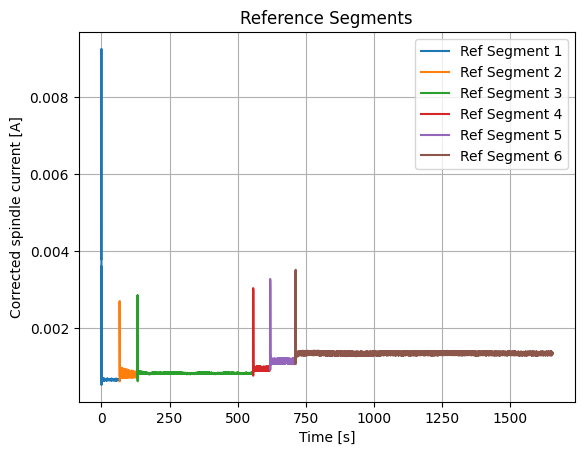

<Figure size 640x480 with 0 Axes>

In [7]:
from signalProcessing.splitSignal import splitSignal
from utils.getFullSegmentIndices import getFullSegmentIndices

indices = getFullSegmentIndices(constantSegmentsIndices[0])

refSegments = splitSignal(correctedDatas[0], indices)
sampleSegments = splitSignal(correctedDatas[1], indices)

# Plot the segments
plt.figure()
for i, segment in enumerate(refSegments):
    plt.plot(segment["timeSeconds"], segment["correctedCurrent"], label=f"Ref Segment {i+1}")
plt.xlabel("Time [s]")
plt.ylabel("Corrected spindle current [A]")
plt.legend()
plt.title("Reference Segments")
plt.grid()
plt.figure()

## Compute offset from sample to reference and subtract it

In [9]:
from utils.findOffsetY import findOffsetY

nbSegments = len(refSegments)
print("Number of segments: ", nbSegments)

offsets = []

for i in range(nbSegments):
    offset, error = findOffsetY(sampleSegments[i]["correctedCurrent"], refSegments[i]["correctedCurrent"])
    print("\nSegment", i+1)
    print("Offset: ", offset.round(2), "A")
    print("RMSE: ", error.round(2), "A")

    offsets.append(offset)

    # add new column to data with the offset removed
    sampleSegments[i]["noOffsetCurrent"] = sampleSegments[i]["correctedCurrent"] - offset

Number of segments:  6

Segment 1
Offset:  -0.0 A
RMSE:  0.0 A

Segment 2
Offset:  -0.0 A
RMSE:  0.0 A

Segment 3
Offset:  -0.0 A
RMSE:  0.0 A

Segment 4
Offset:  -0.0 A
RMSE:  0.0 A

Segment 5
Offset:  -0.0 A
RMSE:  0.0 A

Segment 6
Offset:  -0.0 A
RMSE:  0.0 A


/var/folders/yw/_xsq4q0n0bd5yqsbz7rwv67h0000gp/T/ipykernel_70120/405285671.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampleSegments[i]["noOffsetCurrent"] = sampleSegments[i]["correctedCurrent"] - offset
/var/folders/yw/_xsq4q0n0bd5yqsbz7rwv67h0000gp/T/ipykernel_70120/405285671.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampleSegments[i]["noOffsetCurrent"] = sampleSegments[i]["correctedCurrent"] - offset
/var/folders/yw/_xsq4q0n0bd5yqsbz7rwv67h0000gp/T/ipykernel_70120/405285671.py:17: Se

## Plot original, corrected and no offset data for each segment

First format data and then use the `plotSegments` function.

Issue: there seems to be an X offset. Which is visible because the sample has part of the peak on the right side.

<Figure size 640x480 with 0 Axes>

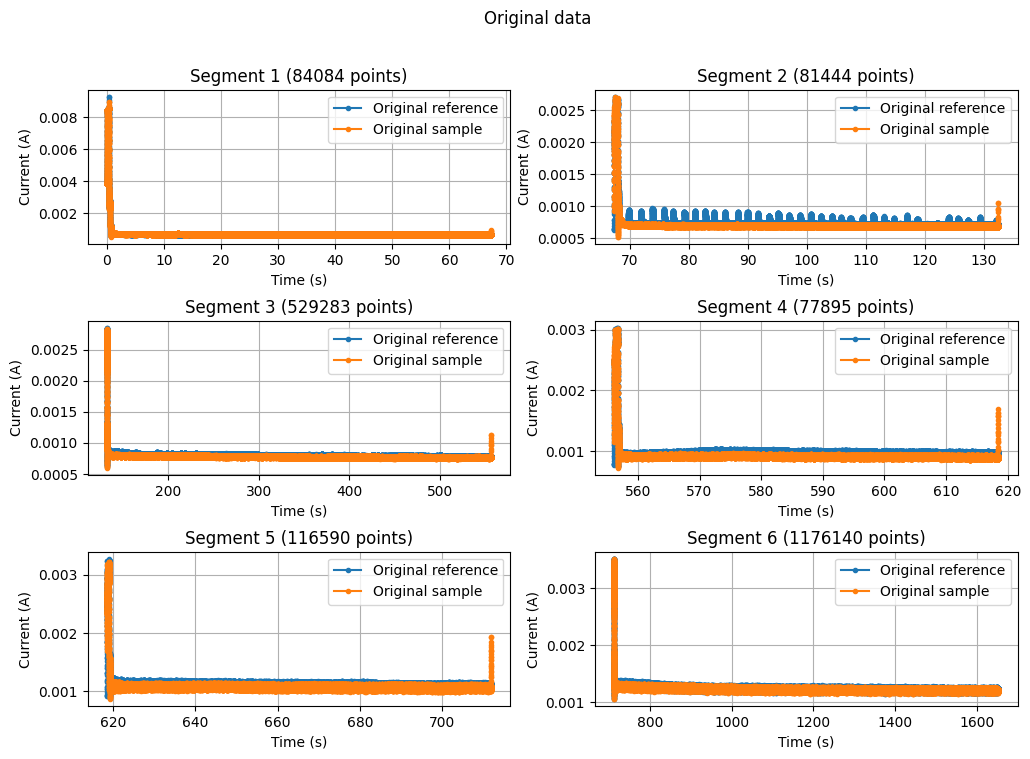

<Figure size 640x480 with 0 Axes>

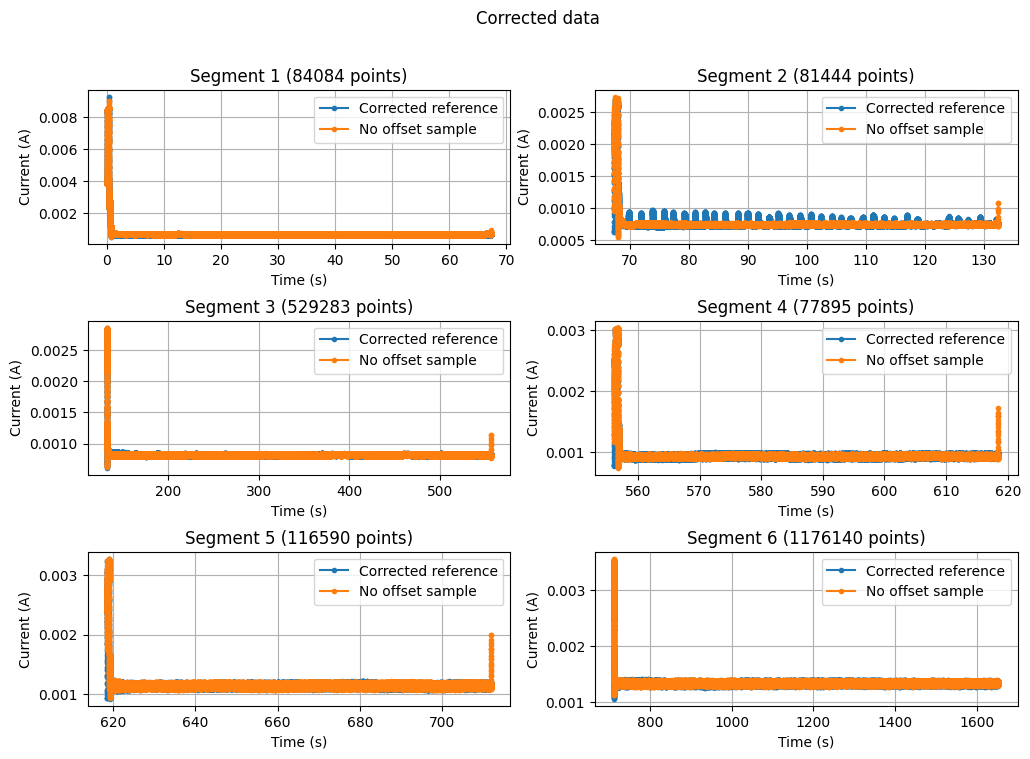

In [10]:
from plot.plotSegments import plotSegments

plotData = []
for i in range(nbSegments):
    segmentData = pd.DataFrame()
    segmentData["timeSeconds"] = refSegments[i]["timeSeconds"]
    segmentData["refCurrent"] = refSegments[i]["current"]
    segmentData["correctedRefCurrent"] = refSegments[i]["correctedCurrent"]
    segmentData["sampleCurrent"] = sampleSegments[i]["current"]
    segmentData["correctedSampleCurrent"] = sampleSegments[i]["correctedCurrent"]
    segmentData["noOffsetSampleCurrent"] = sampleSegments[i]["noOffsetCurrent"]
    plotData.append(segmentData)


# Plot the segments
plotSegments(plotData, "timeSeconds", ["refCurrent", "sampleCurrent"], 
             legend=["Original reference", "Original sample"], title="Original data")

plotSegments(plotData, "timeSeconds", ["correctedRefCurrent", "noOffsetSampleCurrent"], 
             legend=["Corrected reference", "No offset sample"], title="Corrected data")

## Compute original versus corrected RMSE for each segment

In [11]:
originalErrors = []
correctedErrors = []

for i in range(nbSegments):
    originalErrors.append(getRmse(refSegments[i]["current"], sampleSegments[i]["current"]))
    correctedErrors.append(getRmse(refSegments[i]["correctedCurrent"], sampleSegments[i]["noOffsetCurrent"]))

# put the errors in a dataframe
errorsSummary = pd.DataFrame()
errorsSummary["originalError"] = originalErrors
errorsSummary["correctedError"] = correctedErrors

print(errorsSummary)

   originalError  correctedError
0       0.000016        0.000018
1       0.000044        0.000032
2       0.000024        0.000011
3       0.000064        0.000041
4       0.000054        0.000036
5       0.000027        0.000021
